# PCA

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [91]:
class PCA:
    def __init__(self, n_components, whiten, random_state=41, gram_iter=100):
        self.n_components = n_components
        self.whiten = whiten
        self.gram_iter = gram_iter
        
    def covariance(self, x):
        # 공분산을 구하기 위해선 데이터에서 평균을 빼줘야 함
        centered_data = x - np.mean(x, axis=0)
        # 공분산을 구하기 위해선 centered_data를 전치하여 곱해주고
        # 표본 공분산을 구하기 위해선 n-1로 나눠줘야 함
        cov = np.dot(centered_data.T, centered_data) / (x.shape[0] - 1)
        return cov
        
    def whitening(self, x):
        # column 기준으로 평균과 표준편차를 구함
        # x.shape[0] - 1로 나누는 이유는 표준편차를 구할 때 n-1로 나누는 것과 같은 이유
        # x.shape[0]은 column의 개수이고 axis는 column 기준이다.
        # n이 아니라 n-1로 나누는 이유는 표본분산을 구하기 위함이다.

        if(self.whiten == False):
            whitened_data = x
        else:
            mean = np.mean(x, axis=0)
            variance = np.sum((x - mean) ** 2, axis=0) / (x.shape[0] - 1)
            std = np.sqrt(variance)
            whitened_data = (x - mean) /std
        return whitened_data

    def gram_schmidt(self, vectors):
        cov = []
        # v는 vertos의 행을 기준으로 반복문을 돌림
        for v in vectors:
            # u는 cov에 있는 vertor들을 기준으로 반복문을 돌림
            for u in cov:
                v = v - np.dot(u, v) / np.dot(u,u) * u
            # 만약 구한 v가 0에 가깝다면 정규화하여 cov에 추가
            if np.linalg.norm(v) > 1e-10:
                cov.append(v / np.linalg.norm(v))

        # cov를 array로 변환
        cov = np.array(cov)

        # Q 행렬: 직교화된 벡터들로 구성된 행렬
        Q = np.array(cov).T # 각 열이 직교 벡터이므로 전치하여 Q 행렬 구
        R = np.dot(Q.T, vectors) # 직교 벡터들로 구성된 행렬과 원래 벡터들의 내적을 통해 R 행렬 구성
        return Q, R
    
    def eig(self, x, tol=1e-10):
        Q_total = np.eye(x.shape[0]) # 고유벡터를 추적하기 위한 변수
        tmp_x = x.copy() # tmp_x를 계산하기 위한 변수

        for i in range(self.gram_iter):
            Q, R = self.gram_schmidt(tmp_x) # Gram-Schmidt로 QR 분해 수행
            tmp_x = np.dot(R, Q) # 새로운 A_k를 R과 Q의 곱으로 계산
            Q_total = np.dot(Q_total, Q) # 고유벡터를 추적하기 위해 Q 누적
            print(f"지금현재 : {i}번째")

            # 대각성분을 제외한 성분이 0에 가까워지면 종료
            off_diag = np.linalg.norm(tmp_x - np.diag(np.diag(tmp_x)))
            print(f"off_diag : {off_diag}")
            if off_diag < tol: # 대각성분을 제외한 성분이 0에 가까워지면 종료
                break
        
        eigvalues = np.diag(tmp_x) # 고유값은 tmp_x의 대각성분
        eigvectors = Q_total # 고유벡터는 Q_total에 누적된 값

        return eigvalues, eigvectors
    
    def fit(self, data):
        # 데이터를 whitening하여 데이터의 평균을 0으로 만들고 표준편차를 1로 만듬
        data = self.whitening(data)
        print("finish whitening")
        # 데이터의 공분산을 구함
        covariance_matrix = self.covariance(data)
        print("finish covariance")
        # 공분산의 고유값과 고유벡터를 구함
        eigvalues, eigvectors = self.eig(covariance_matrix)
        print("finish eig")

        # 큰 고유값 순으로 정렬 (내림차순 정렬)
        idx = np.argsort(eigvalues)[::-1]
        eigvalues = eigvalues[idx]
        eigvectors = eigvectors[:, idx]
        print("finish sort")

        # 고유벡터 행렬은 보통 열이 고유벡터이고 행이 데이터의 차원이다.
        print("finish pca")
        pca_output_eigvectors = eigvectors
        return pca_output_eigvectors
        

In [92]:
people = fetch_lfw_people(min_faces_per_person=100, resize=0.3)
image_shape = people.images[0].shape
print("dataset keys        : ", people.keys())
print("dataset.images shape: ", people.images.shape)
print("dataset.data shape  : ", people.data.shape)
print("dataset.target shape: ", people.target.shape)

dataset keys        :  dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
dataset.images shape:  (1140, 37, 28)
dataset.data shape  :  (1140, 1036)
dataset.target shape:  (1140,)


In [93]:
pca = PCA(200, False)
total_component_data = pca.fit(people.data)
pca_w = PCA(200, True)
total_component_data_w = pca_w.fit(people.data)

finish whitening
finish covariance
지금현재 : 0번째
off_diag : 4.864997863769531
지금현재 : 1번째
off_diag : 2.1876933574676514
지금현재 : 2번째
off_diag : 1.3519177436828613
지금현재 : 3번째
off_diag : 1.0298963785171509
지금현재 : 4번째
off_diag : 0.7873088717460632
지금현재 : 5번째
off_diag : 0.5959940552711487
지금현재 : 6번째
off_diag : 0.46760717034339905
지금현재 : 7번째
off_diag : 0.33496642112731934
지금현재 : 8번째
off_diag : 0.25490546226501465
지금현재 : 9번째
off_diag : 0.19642746448516846
지금현재 : 10번째
off_diag : 0.15884344279766083
지금현재 : 11번째
off_diag : 0.13828623294830322
지금현재 : 12번째
off_diag : 0.10543303936719894
지금현재 : 13번째
off_diag : 0.08558593690395355
지금현재 : 14번째
off_diag : 0.07216713577508926
지금현재 : 15번째
off_diag : 0.06484033167362213
지금현재 : 16번째
off_diag : 0.0652260035276413
지금현재 : 17번째
off_diag : 0.06077437102794647
지금현재 : 18번째
off_diag : 0.043804097920656204
지금현재 : 19번째
off_diag : 0.04216311499476433
지금현재 : 20번째
off_diag : 0.038453780114650726
지금현재 : 21번째
off_diag : 0.034983109682798386
지금현재 : 22번째
off_diag : 0.034063704

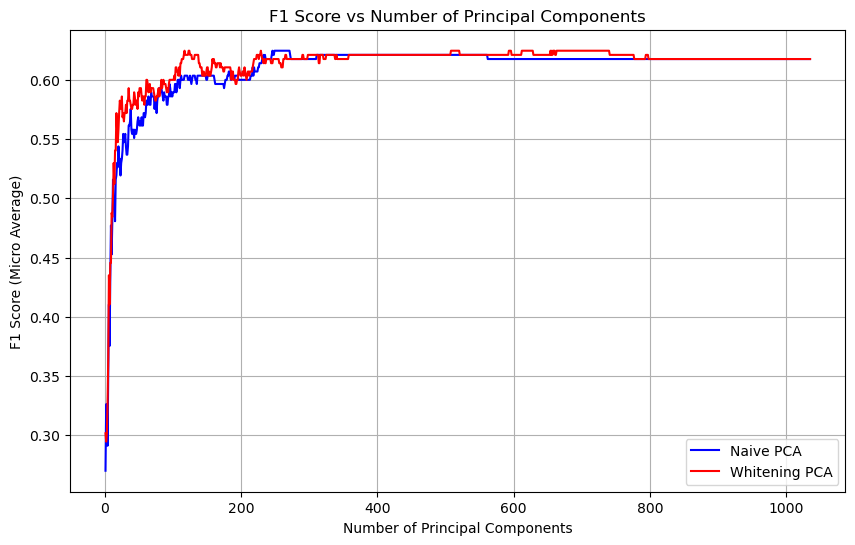

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# F1 scores 저장할 리스트
f1_scores_naive = []
f1_scores_whitening = []

# 주성분 개수의 범위 설정
component_range = range(1, 1036)

# 각 주성분 개수마다 F1 스코어 계산 및 저장
for i in component_range:
    n_component_data = np.dot(people.data, total_component_data[:, :i])  # i개의 주성분 사용
    n_component_data_w = np.dot(people.data, total_component_data_w[:, :i])
    
    X_train, X_test, y_train, y_test = train_test_split(n_component_data, people.target, test_size=0.25, random_state=41)
    X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(n_component_data_w, people.target, test_size=0.25, random_state=41)
    
    knn = knc(n_neighbors=1)
    knn_w = knc(n_neighbors=1)
    
    knn.fit(X_train, y_train)
    knn_w.fit(X_train_w, y_train_w)
    
    y_pred = knn.predict(X_test)
    y_pred_w = knn_w.predict(X_test_w)
    
    # F1 score 계산
    f1_naive = f1_score(y_test, y_pred, average='micro')
    f1_whitening = f1_score(y_test_w, y_pred_w, average='micro')
    
    # F1 score 저장
    f1_scores_naive.append(f1_naive)
    f1_scores_whitening.append(f1_whitening)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(component_range, f1_scores_naive, label="Naive PCA", color='blue')
plt.plot(component_range, f1_scores_whitening, label="Whitening PCA", color='red')
plt.xlabel('Number of Principal Components')
plt.ylabel('F1 Score (Micro Average)')
plt.title('F1 Score vs Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()


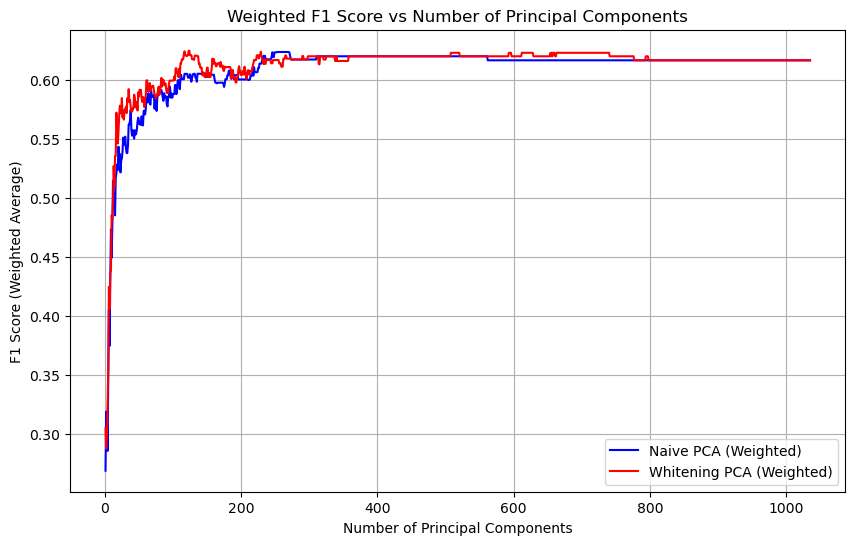

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# F1 scores 저장할 리스트
f1_scores_naive = []
f1_scores_whitening = []

# 주성분 개수의 범위 설정
component_range = range(1, 1036)

# 각 주성분 개수마다 F1 스코어 계산 및 저장
for i in component_range:
    n_component_data = np.dot(people.data, total_component_data[:, :i])  # i개의 주성분 사용
    n_component_data_w = np.dot(people.data, total_component_data_w[:, :i])
    
    X_train, X_test, y_train, y_test = train_test_split(n_component_data, people.target, test_size=0.25, random_state=41)
    X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(n_component_data_w, people.target, test_size=0.25, random_state=41)
    
    # KNN with weighted distance
    knn = knc(n_neighbors=1)
    knn_w = knc(n_neighbors=1)
    
    knn.fit(X_train, y_train)
    knn_w.fit(X_train_w, y_train_w)
    
    y_pred = knn.predict(X_test)
    y_pred_w = knn_w.predict(X_test_w)
    
    # F1 score 계산 (가중치 적용)
    f1_naive = f1_score(y_test, y_pred, average='weighted')
    f1_whitening = f1_score(y_test_w, y_pred_w, average='weighted')
    
    # F1 score 저장
    f1_scores_naive.append(f1_naive)
    f1_scores_whitening.append(f1_whitening)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(component_range, f1_scores_naive, label="Naive PCA (Weighted)", color='blue')
plt.plot(component_range, f1_scores_whitening, label="Whitening PCA (Weighted)", color='red')
plt.xlabel('Number of Principal Components')
plt.ylabel('F1 Score (Weighted Average)')
plt.title('Weighted F1 Score vs Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()


# KNN

In [95]:
from sklearn.neighbors import KNeighborsClassifier as knc # KNN

In [96]:
knn = knc(n_neighbors=1) # KNN 모델 생성
knn_w = knc(n_neighbors=1) # whitening KNN 모델 생성

In [97]:
knn.fit(X_train, y_train) # KNN 모델 학습
knn_w.fit(X_train_w, y_train_w) # whitening KNN 모델 학습

KNeighborsClassifier(n_neighbors=1)

In [98]:
y_pred = knn.predict(X_test)
y_pred_w = knn_w.predict(X_test_w)

# Results
#### -F1 score를 각 채점 항목 별로 출력하면 됩니다

In [99]:
from sklearn.metrics import f1_score # F1 score 계산 함수

In [100]:
print(f"Naive PCA: {f1_score(y_test, y_pred, average='micro')}\nWhitening PCA: {f1_score(y_test_w, y_pred_w, average='micro')}")  # F1 score 출력

Naive PCA: 0.6
Whitening PCA: 0.6035087719298246
